# Classification de genres musicaux

Lionel Baptiste, Ghali El Ouarzazi, Joévin Soulenq

Basé sur les travaux de Michaël Defferrard : https://github.com/mdeff/fma

## Comparaison des performances des classifieurs

* apprentissage des données sur 7 différents classifieurs
* affiche la précision
* affiche le temps d'exécution
* affiche la matrice de confusion normalisée

In [2]:
import time
import os

import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets
from sklearn.metrics import confusion_matrix

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import utils

In [3]:
# On charge les fichiers
tracks = utils.load('fma_metadata/tracks.csv')
features = utils.load('fma_metadata/features.csv')

In [4]:
# charge la version "medium"
small = tracks['set', 'subset'] <= 'medium'
# validation croisée
train = tracks['set', 'split'] == 'training'
val   = tracks['set', 'split'] == 'validation'
test  = tracks['set', 'split'] == 'test'
# sélection des labels et des attributs
y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_test  = tracks.loc[small & test,  ('track', 'genre_top')]
X_train = features.loc[small & train, 'mfcc']
X_test  = features.loc[small & test,  'mfcc']

In [5]:
# Mélange l'ensemble des attributs (indispensable)
X_train, y_train = shuffle(X_train, y_train, random_state=42)
# Standardise les données : retire la moyenne et réduit la variance
scaler = StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test);

In [6]:
classifiers = {
    'Naïve de Bayes (Gaussienne) :': GaussianNB(),
    'Arbres décisionnels :': DecisionTreeClassifier(max_depth=5),
    'KPPV (k=200) :': KNeighborsClassifier(n_neighbors=200),
    'Régression logistique :': LogisticRegression(),
    'Réseaux monocouche à 10 neurones :': MLPClassifier(hidden_layer_sizes=(10), max_iter=1000),
    'Réseaux multicouche à 2*10 neurones :': MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000),
    'Machine à vecteurs de support (SVM) :': SVC(kernel='rbf'),
}

for clf_name, clf in classifiers.items():
    print(clf_name)
    t = time.process_time()
    clf.fit(X_train, y_train) # classification
    score = clf.score(X_test, y_test)
    print('Précision : {:.2%}'.format(score))
    print('Temps d\'exécution : {:.2f} secondes\n'.format(time.process_time() - t))

Naïve de Bayes (Gaussienne)	:
Précision : 41.86%
Temps d'exécution : 0.08 secondes

Arbres décisionnels		:
Précision : 45.82%
Temps d'exécution : 1.72 secondes

KPPV (k=200)			:
Précision : 54.99%
Temps d'exécution : 17.17 secondes

Régression logistique		:
Précision : 57.83%
Temps d'exécution : 37.22 secondes

Réseaux monocouche à 10 neurones	:
Précision : 58.80%
Temps d'exécution : 145.80 secondes

Réseaux multicouche à 2*10 neurones	:
Précision : 58.41%
Temps d'exécution : 224.50 secondes

Machine à vecteurs de support (SVM)	:
Précision : 60.98%
Temps d'exécution : 97.22 secondes



## Matrice de confusion

S'applique au dernier classifieur entraîné : SVM

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matrice de confusion',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis];

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Valeur observée ')
    plt.xlabel('Valeur prédite')
    plt.tight_layout()

In [24]:
y_pred = clf.predict(X_test) # prédiction

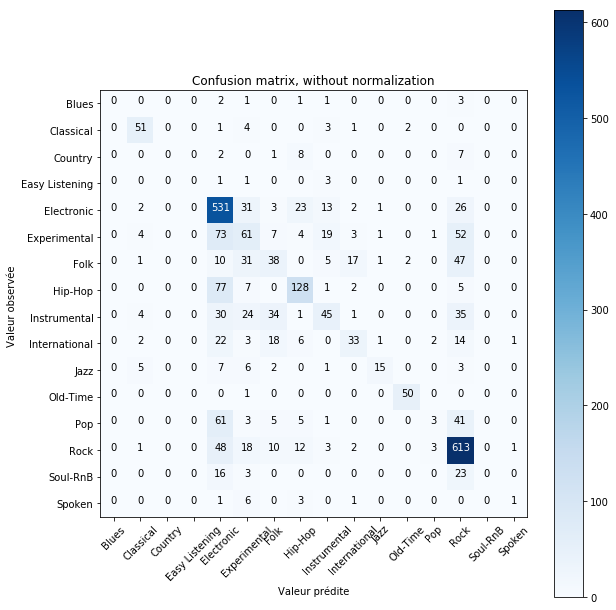

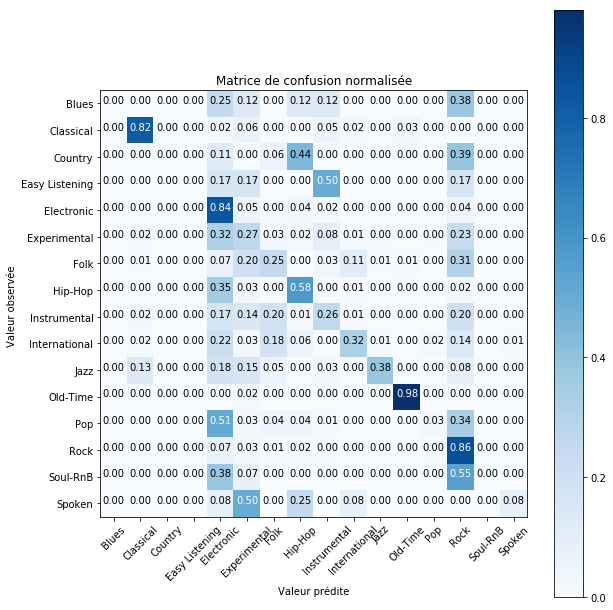

In [25]:
class_names = ['Blues', 'Classical', 'Country', 'Easy Listening', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Jazz', 'Old-Time', 'Pop', 'Rock', 'Soul-RnB', 'Spoken']
plt.rcParams['figure.figsize'] = (9, 9)

# Calcule la matrice de confusion
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure() # Affiche la matrice de confusion non-normalisée
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

plt.figure() # Affiche la matrice de confusion normalisée
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Matrice de confusion normalisée')
plt.show()